# Introduction

This notebook provides a basic example of how to load and perform preprocessing on histological (.mrxs) and hyperspectral (ENVI) data using Python.

This notebook was designed as a basic tutorial on how to load data from the HistologyHSI-BRCA-Recurrence Dataset.

# 1) Setting up the environment and downloading the example data

### Libraries:
The libraries required for this notebook are Spectral Python (SPy), NumPy, SciPy, and Matplotlib.

> Openslide. Python module for reading whole-slide image formats. https://openslide.org/  

> Spectral Python (SPy). Python module for hyperspectral image processing. https://www.spectralpython.net

> Harris, C.R., Millman, K.J., van der Walt, S.J. et al. Array programming with NumPy. Nature 585, 357–362 (2020). https://doi.org/10.1038/s41586-020-2649-2

> J. D. Hunter, "Matplotlib: A 2D Graphics Environment," in Computing in Science & Engineering, vol. 9, no. 3, pp. 90-95, May-June 2007, doi: 10.1109/MCSE.2007.55.

> Virtanen, P., Gommers, R., Oliphant, T.E. et al. SciPy 1.0: fundamental algorithms for scientific computing in Python. Nat Methods 17, 261–272 (2020). https://doi.org/10.1038/s41592-019-0686-2





### Data:

The data used on this notebook correspond to a folder containing histological and hyperspectral data from a breast histological slide from the HistologyHSI-BRCA-Recurrence dataset.  The demographic and clinical data are stores as excel, the histological slide are stored as mrxs files and the hyperspectral cubes from the histological slide and the white and dark references are stored as ENVI files. The ENVI format is the concention for HSI data and it consists of a flat-binary raster file with an accompanying ASCII header file.



In [ ]:
# Install the Spectral Python (SPy) library
!pip install spectral
!pip install openslide-python
!pip install openslide-bin

# Download a folder containing the hyperspectral data from the HistologyHSI-GB dataset from TCIA
#!apt install -y ruby ruby-dev rubygems ruby-json
#!gem install aspera-cli
#!ascli conf ascp install
#!ascli faspex5 packages receive --url='https://faspex.cancerimagingarchive.net/aspera/faspex/public/package?context=eyJyZXNvdXJjZSI6InBhY2thZ2VzIiwidHlwZSI6ImV4dGVybmFsX2Rvd25sb2FkX3BhY2thZ2UiLCJpZCI6Ijc2NCIsInBhc3Njb2RlIjoiMGU0MzFhYTFjN2ZhOGMwZWJmNTRhZDVkZTQxOGY5NWVlNmYyMjhlNiIsInBhY2thZ2VfaWQiOiI3NjQiLCJlbWFpbCI6ImhlbHBAY2FuY2VyaW1hZ2luZ2FyY2hpdmUubmV0In0=' P1/ROI_01_C01_T

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 22.8 MB/s eta 0:00:00


In [ ]:
!wget -O downloaded_file.zip 'https://nimbus.iuma.ulpgc.es/s/JaxL6Rb4G74Wz6x/download'
!unzip downloaded_file.zip && rm downloaded_file.zip

--2025-01-31 13:12:21--  https://nimbus.iuma.ulpgc.es/s/JaxL6Rb4G74Wz6x/download
Resolving nimbus.iuma.ulpgc.es (nimbus.iuma.ulpgc.es)... 193.145.147.66
Connecting to nimbus.iuma.ulpgc.es (nimbus.iuma.ulpgc.es)|193.145.147.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘downloaded_file.zip’

downloaded_file.zip     [<=>                 ]   2.80G  13.1MB/s    in 3m 37s  

2025-01-31 13:15:59 (13.2 MB/s) - ‘downloaded_file.zip’ saved [3007677160]

Archive:  downloaded_file.zip
   creating: Scientific Data/
 extracting: Scientific Data/00_01_Clinical_Demographic_Data.xlsx  
   creating: Scientific Data/01_01_Histological_Images/
   creating: Scientific Data/01_01_Histological_Images/15_07B3634/
 extracting: Scientific Data/01_01_Histological_Images/15_07B3634/Data0000.dat  
 extracting: Scientific Data/01_01_Histological_Images/15_07B3634/Data0001.dat  
 extracting: Scientific Data/01_01_Histological_Images/15_07B3634/

# 2) Analyse Demographic and Clinical data

Load the Excel file containing demographic and clinical data and display the information for patient 15.

In [ ]:
import pandas as pd

In [ ]:
file_path = '/content/Scientific Data/00_01_Clinical_Demographic_Data.xlsx';
demographic_clinical_data = pd.read_excel(file_path)
demographic_clinical_data.head(1)

,Case,Sex,Race,Ethnicity,Menopausal_status,Dx_surgery,Dx_date,Dx_age,Tumor_diameter,Tumor_histologic_grade,...,Tx_RT,Last_follow_up,Relapse,Metastasis_type,Relapse_date,DFS,Vital_status,Death_date,Death_cause,OS
0,15,1,1,1,1,1,2007-04-23,49,35.0,3,...,1,2021-11-23,0,0,NaT,175,0,NaT,0,175


# 3) Analyse Histology data

In [ ]:
%reset -f

In [ ]:
import json
import openslide
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [ ]:
FILE_PATH = '/content/Scientific Data/01_01_Histological_Images/15_07B3634.mrxs'
ANNOTATION_GEOJSON_PATH = '/content/Scientific Data/01_03_HSI ROI_Annotations/15.geojson'
ROI_NAME = 'IDC_C01'

In [ ]:
# Load geojson data
geojson_data = ""
with open(ANNOTATION_GEOJSON_PATH, "r") as file:
    geojson_data = json.load(file)

# Search for the selected ROI in the geojson data
selected_geojson_roi = ""
i = 0
geojson_features = geojson_data['features']
while i < len(geojson_features):
    if geojson_features[i]['id'][0] == ROI_NAME:
        selected_geojson_roi = geojson_features[i]
        break
    i += 1

# List with the coordinates of the ROI vertices
coordinates_selected_geojson_roi = selected_geojson_roi['geometry']['coordinates'][0][:4]

Update the ROI coordinates, as the GeoJSON data is misaligned with the offset.

In [ ]:
selected_image = openslide.OpenSlide(FILE_PATH)
shift_x = selected_image.properties['openslide.bounds-x']
shift_x = int(shift_x)
shift_y = selected_image.properties['openslide.bounds-y']
shift_y = int(shift_y)
coordinates_selected_geojson_roi = [[x + shift_x, y + shift_y] for [x, y] in coordinates_selected_geojson_roi]

# Remove the bounding box containing the ROI
x_coords, y_coords = zip(*coordinates_selected_geojson_roi)
x_min, x_max = min(x_coords), max(x_coords)
y_min, y_max = min(y_coords), max(y_coords)

# Define the size of the bounding box
width = x_max - x_min
height = y_max - y_min

In [ ]:
# Extract the region from the bounding box
level = 0  # Magnification level
bounding_box = selected_image.read_region(location=(x_min, y_min), level=level, size=(width, height))

# Convert to RGB
bounding_box = bounding_box.convert("RGB")

# Create a mask for the ROI
mask = Image.new("L", (width, height), 0)  # Create a black mask
polygon_relative = [(x - x_min, y - y_min) for x, y in coordinates_selected_geojson_roi]  # Fit polygon to bounding box
ImageDraw.Draw(mask).polygon(polygon_relative, outline=255, fill=255)

# Apply the mask to the image
masked_region = Image.composite(bounding_box, Image.new("RGB", (width, height)), mask)

# Rotate the image to match the HSI image capture
masked_region = masked_region.rotate(180)

In [ ]:
# Save the extracted ROI as an image
masked_region.save("extracted_roi.png")

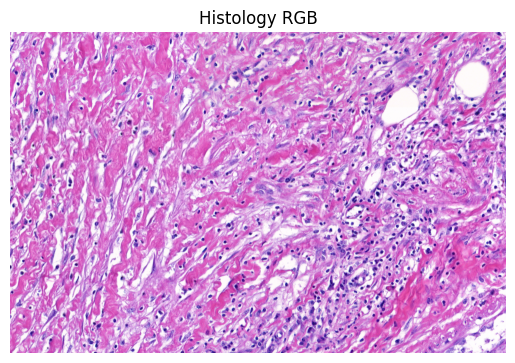

In [ ]:
# Display the resulting image
plt.imshow(masked_region)
plt.title('Histology RGB')
plt.axis('off')  # Optional, to remove the axes
plt.show()

# 4) Analyse Hyperspectral data

In [ ]:
%reset -f

In [ ]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
from spectral import *
import scipy

Load the RGB and synthetic RGB from the hyperspectral cube for analysis.

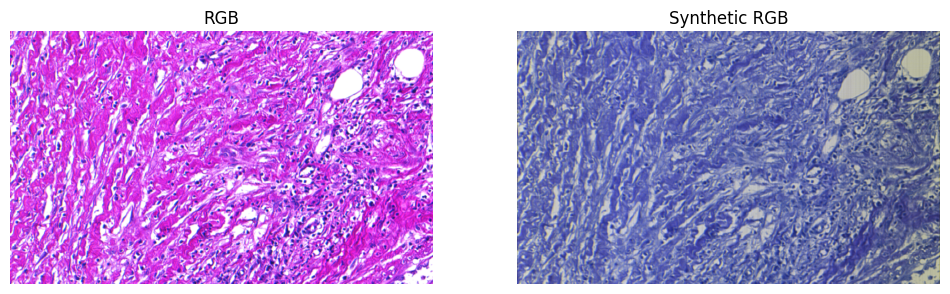

In [ ]:
# Load RGB and synthetic RGB
rgb_file_name = '/content/Scientific Data/02_01_HSI_Images/IDC/HS_VNIR_15_IDC_x10_C01/RGBImage.png';
synthetic_rgb_file_name = '/content/Scientific Data/02_01_HSI_Images/IDC/HS_VNIR_15_IDC_x10_C01/SyntheticRGBImage.png';

rgb = Image.open(rgb_file_name)
synthetic_rgb = Image.open(synthetic_rgb_file_name)

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Display the images in each subplot
axes[0].imshow(rgb)
axes[0].set_title('RGB')
axes[0].axis('off')  # Optional, to hide the axes
axes[1].imshow(synthetic_rgb)
axes[1].set_title('Synthetic RGB')
axes[1].axis('off')  # Optional, to hide the axes

# Show the figure
plt.show()

Define helper functions to load and preprocess the HSI.

In [ ]:
def read_hyperspectral_cube(file_name):
    """Function used to read an ENVI hyperspectral image, and return a numpy
    data structure containing the 3D hyperspectral cube

    Parameters
    ----------
    file_name : str
        The file location of the ENVI header related to the hyperspectral data.

    Returns
    -------
    hyperspectral_data: ndarray
        3-dimensional numpy array containing the hyperspectral cube
    wavelengths: ndarray
        1-dimensional numpy array containing the spectral bands corresponding to
        the hyperspectral cube
    """

    ENVI_structure = envi.open(file_name)
    hyperspectral_data = ENVI_structure.load()
    wavelengths = ENVI_structure.bands.centers
    return hyperspectral_data, wavelengths

def hyperspectral_calibration(raw_data, white_reference, dark_reference):
    """Perform the calibration of a hyperspectral imaging using a white and
    dark reference images.

    Parameters
    ----------
    raw_data : ndarray
        Array containing the raw hyperspectral cube
    white_reference : ndarray
        Array containing the white reference
    dark_reference : ndarray
        Array containing the dark reference
    Returns
    -------
    ndarray
        Calibrated hyperspectral cube
    """
    return (raw_data-dark_reference)/(white_reference-dark_reference)

def band_reduction(input_data, wavelengths, n = 3):
    """Perform the band reduction to the hyperspectral cube

    Parameters
    ----------
    input_data : ndarray
        Array containing the raw hyperspectral cube
    wavelengths : ndarray
        1-dimensional numpy array containing the spectral bands corresponding to
        the hyperspectral cube
    n : Integer
        Width of the window used for the moving average window.
    Returns
    -------
    band_reduced_cube: ndarray
        3-dimensional numpy array containing the hyperspectral cube after the
        band reduction
    wavelength_reduced: ndarray
        1-dimensional numpy array containing the spectral bands corresponding to
        the hyperspectral cube after the band reduction
    """
    w = np.ones(n)/n
    moving_averaged_image = scipy.ndimage.convolve1d(calibrated_hyperspectral_image, w, axis=2)
    band_reduced_cube = moving_averaged_image[:,:,1:-1:n]
    wavelength_reduced = wavelenghts[1:-1:n]
    return band_reduced_cube, wavelength_reduced

**Load the hyperspectral images and check their sizes:**

The raw hyperspectral image has a dimension of (800, 1004, 826), where the first two dimensions correspond to the spatial information (800x1004 pixels), and the third dimension corresponding to the spectral information (826 bands).

The white and dark reference have a dimension of (1, 1004, 826), since there is only information about a single line across the field of view of the camera. These reference were obtained as an average of 100 consecutive measurements of the white and dark references.

In [ ]:
# Define the file names for the raw image, the white reference and the dark reference
raw_file_name = '/content/Scientific Data/02_01_HSI_Images/IDC/HS_VNIR_15_IDC_x10_C01/raw.hdr'
white_reference_file_name = '/content/Scientific Data/02_01_HSI_Images/IDC/HS_VNIR_15_IDC_x10_C01/whiteReference.hdr'
dark_reference_file_name = '/content/Scientific Data/02_01_HSI_Images/IDC/HS_VNIR_15_IDC_x10_C01/darkReference.hdr'
calibrated_file_name = '/content/Scientific Data/02_01_HSI_Images/IDC/HS_VNIR_15_IDC_x10_C01/calibrated.hdr'

# Use the function read_hyperspectral_cube to load the ENVI files into numpy
# arrays. The spectral bands (wavelengths) for the white and dark references
# are the same ones we have for the hyperspectral cube, so it is no necesary
# to also get them.
raw_hyperspectral_image, wavelenghts = read_hyperspectral_cube(raw_file_name)
white_reference, _ = read_hyperspectral_cube(white_reference_file_name)
dark_reference, _ = read_hyperspectral_cube(dark_reference_file_name)
calibrated_hyperspectral_image, _ = read_hyperspectral_cube(calibrated_file_name)

# Divide by 10^4 to revert the scaling applied during saving, which was done to store the data as integers instead of floats.
calibrated_hyperspectral_image = calibrated_hyperspectral_image / 10**4


# Display data dimensions:
print("Raw hyperspectral image dimensions: " + str(raw_hyperspectral_image.shape))
print("White reference dimensions: " + str(white_reference.shape))
print("Dark reference dimensions: " + str(dark_reference.shape))
print("Calibrated hyperspectral image dimensions: " + str(calibrated_hyperspectral_image.shape))

# Display some information about the spectral bands:
print("Min. wavelength (nm): " + str(wavelenghts[0]))
print("Max. wavelength (nm): " + str(wavelenghts[-1]))
print("Distance between consecutive spectral bands (nm): " + str(np.mean(np.diff(wavelenghts))))

Raw hyperspectral image dimensions: (600, 1004, 740)
White reference dimensions: (1, 1004, 740)
Dark reference dimensions: (100, 1004, 740)
Calibrated hyperspectral image dimensions: (600, 1004, 740)
Min. wavelength (nm): 400.482
Max. wavelength (nm): 938.16
Distance between consecutive spectral bands (nm): 0.7275751014884978


**Perform preprocessing (optional):**

In [ ]:
# TODO: Optional. Perform the band reduction.
band_reduced_hyperspectral_image, reduced_wavelengths = band_reduction(calibrated_hyperspectral_image, wavelenghts)

# Display data dimensions:
print("Calibrated hyperspectral image dimensions: " + str(calibrated_hyperspectral_image.shape))
print("Band-reduced hyperspectral image dimensions: " + str(band_reduced_hyperspectral_image.shape))

# Display some information about transmittance:
print("Min. transmittance (nm): " + str(np.min(calibrated_hyperspectral_image)))
print("Max. transmittance (nm): " + str(np.max(calibrated_hyperspectral_image)))

# Display some information about the reduced spectral bands:
print("Min. wavelength (nm): " + str(reduced_wavelengths[0]))
print("Max. wavelength (nm): " + str(reduced_wavelengths[-1]))
print("Distance between consecutive spectral bands (nm): " + str(np.mean(np.diff(reduced_wavelengths))))

Calibrated hyperspectral image dimensions: (600, 1004, 740)
Band-reduced hyperspectral image dimensions: (600, 1004, 246)
Min. wavelength (nm): 401.21
Max. wavelength (nm): 935.977
Distance between consecutive spectral bands (nm): 2.1827224489795922
Min. transmittance (nm): 0.0
Max. transmittance (nm): 1.8972


**Representation of the information from the hyprespectral data**:

Visualizing the spatial information for different spectral bands

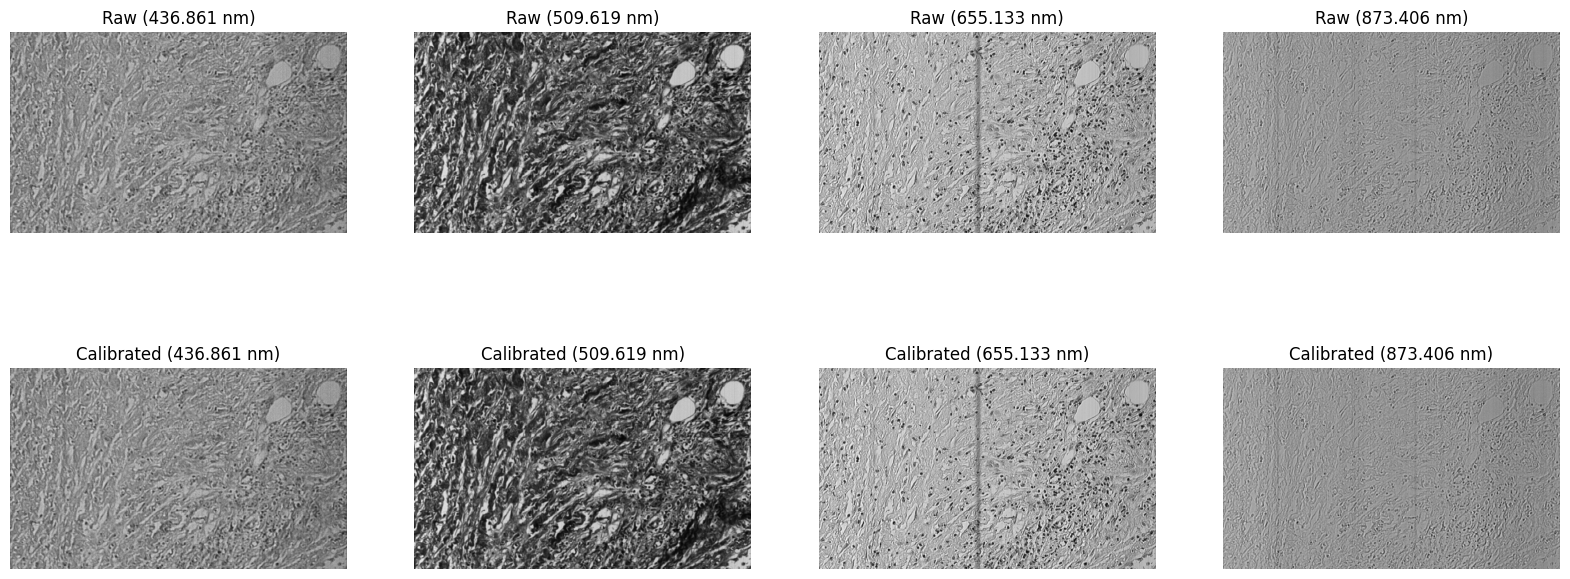

In [ ]:
f, axarr = plt.subplots(2,4, figsize=(20, 8))

band_list = [50, 150, 350, 650]

for idx, current_band in enumerate(band_list):
  axarr[0,idx].imshow(raw_hyperspectral_image[:,:,current_band],cmap='gray')
  axarr[0,idx].set_title("Raw (" + str(wavelenghts[current_band]) + " nm)")
  axarr[0,idx].axis('off')

  axarr[1,idx].imshow(calibrated_hyperspectral_image[:,:,current_band],cmap='gray')
  axarr[1,idx].set_title("Calibrated (" + str(wavelenghts[current_band]) + " nm)")
  axarr[1,idx].axis('off')

Visualizing the spectral information of different pixels

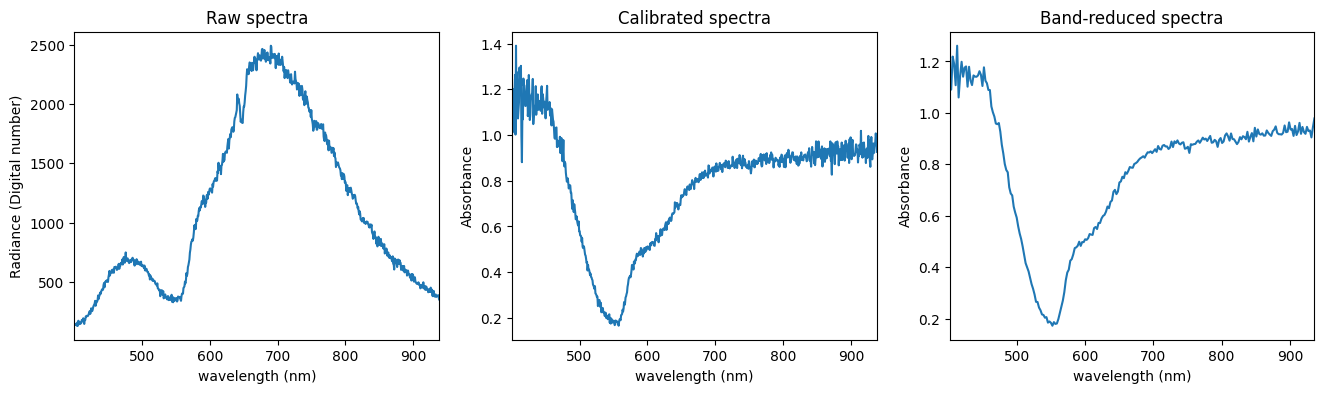

In [ ]:
f, axarr = plt.subplots(1,3, figsize=(16, 4))

x_coordinate = 300
y_coordinate = 500

# Represent some bands from the raw image
axarr[0].plot(wavelenghts, np.squeeze(raw_hyperspectral_image[y_coordinate,x_coordinate,:]))
axarr[0].set_title("Raw spectra")
axarr[0].set_xlabel("wavelength (nm)")
axarr[0].set_ylabel("Radiance (Digital number)")
axarr[0].set_xlim(wavelenghts[0], wavelenghts[-1])


axarr[1].plot(wavelenghts, np.squeeze(calibrated_hyperspectral_image[y_coordinate,x_coordinate,:]))
axarr[1].set_title("Calibrated spectra")
axarr[1].set_xlabel("wavelength (nm)")
axarr[1].set_ylabel("Absorbance")
axarr[1].set_xlim(wavelenghts[0], wavelenghts[-1])


axarr[2].plot(reduced_wavelengths, np.squeeze(band_reduced_hyperspectral_image[y_coordinate,x_coordinate,:]))
axarr[2].set_title("Band-reduced spectra")
axarr[2].set_xlabel("wavelength (nm)")
axarr[2].set_ylabel("Absorbance")
axarr[2].set_xlim(reduced_wavelengths[0], reduced_wavelengths[-1]);

